In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import numpy as np
from math import *
from scipy.signal import argrelextrema

import networkx as nx

import seaborn as sns
sns.set()
sns.set_context("notebook", font_scale=1.75, rc={"lines.linewidth": 4.0})

plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [2]:
def readEdges(filename):
    edges=np.loadtxt(filename)
    edges.sort()
    edges.sort(axis=0)
    return edges

def readTrigs(filename):
    trigs=np.loadtxt(filename)
    trigs.sort()
    trigs.sort(axis=0)
    return trigs

In [3]:
def B1fromEdges(n, edges):
    B1=np.zeros((n, edges.shape[0]))

    for i in range(edges.shape[0]):
        B1[int(edges[i, 0]),i]=-1
        B1[int(edges[i, 1]),i]=1
    return B1

def B2fromTrig(n, edges, trigs):
    B2=np.zeros((len(edges), trigs.shape[0]))

    for i in range(trigs.shape[0]):
        B2[np.where((edges==np.array([trigs[i, 0], trigs[i, 1]])).all(axis=1))[0][0] ,i]=1
        B2[np.where((edges==np.array([trigs[i, 0], trigs[i, 2]])).all(axis=1))[0][0] ,i]=1
        B2[np.where((edges==np.array([trigs[i, 1], trigs[i, 2]])).all(axis=1))[0][0] ,i]=-1
    return B2

In [4]:
n=7
edges=readEdges('6.edges')
trigs=readTrigs('6.trigs')

In [5]:
B1=B1fromEdges(n, edges)
B2=B2fromTrig(n, edges, trigs)

In [6]:
def getRandomWeights(edges):
    return np.random.uniform(size=(edges.shape[0]))

In [7]:
w=getRandomWeights(edges)
w=np.array([1, 1, 1, 1, 1, 1, 1, 0.25, 1, 1])

In [8]:
def getAdjB1(B1):
    return np.diag(np.diag(B1.dot(B1.T)))-B1.dot(B1.T)

In [9]:
A=getAdjB1(B1)
G = nx.from_numpy_matrix(np.array(A))  
pos = nx.spring_layout(G)

In [16]:
def inv(A):
    w=np.diag(A)
    thr=1e-10
    ans=np.zeros(w.shape[0])
    ans[np.abs(w)<thr]=0
    ans[np.abs(w)>=thr]=np.divide(1, w[np.abs(w)>=thr])
    return np.diag(ans)

In [17]:
def getPosFromB1(B1):
    A=getAdjB1(B1)
    G = nx.from_numpy_matrix(np.array(A))  
    pos = nx.spring_layout(G)
    return np.array(list(pos.values()))

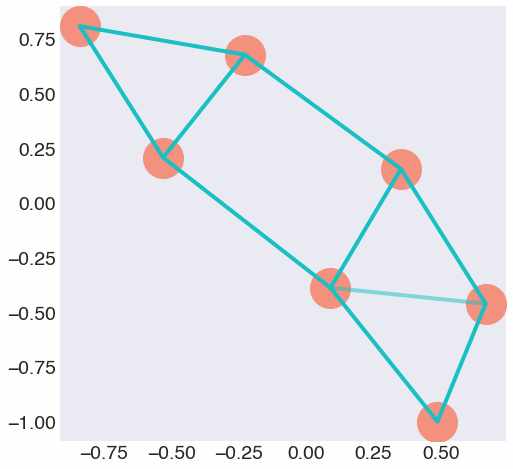

In [18]:
points=getPosFromB1(B1)
plt.figure(figsize=(8,8))
#plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o', color=colors[4], markersize=40)

for i in range(edges.shape[0]):
    plt.plot(points[edges[i].astype(int), 0], points[edges[i].astype(int), 1], color=colors[3], alpha=np.sqrt(w[i]))
plt.grid(False)

([], [])

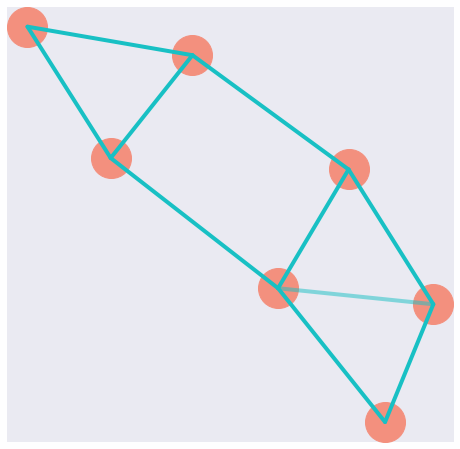

In [19]:
plt.figure(figsize=(8,8))
plt.plot(points[:,0], points[:,1], 'o', color=colors[4], markersize=40)

for i in range(edges.shape[0]):
    plt.plot(points[edges[i].astype(int), 0], points[edges[i].astype(int), 1], color=colors[3], alpha=np.sqrt(w[i]))
plt.grid(False)
plt.xticks([], [])
plt.yticks([], [])

In [20]:
def simpleDrawB1(B1, w, points, eps=0, e=0):
    
    plt.figure(figsize=(8,8))
    plt.plot(points[:,0], points[:,1], 'o', color=colors[4], markersize=40)
    for i in range(points.shape[0]):
        plt.annotate(str(i), (points[i,0], points[i,1]))
    for i in range(edges.shape[0]):
        plt.plot(points[edges[i].astype(int), 0], points[edges[i].astype(int), 1], color=colors[3], linewidth=8*((np.sqrt(w)+eps*e)**2)[i])
    plt.grid(False)
    plt.xticks([], [])
    plt.yticks([], [])

In [22]:
def HodgeLW_fr(B1, B2, w, e=0, eps=0):
    W=np.diag(np.sqrt(w)+eps*e)
    Dt=1./3.*np.diag(np.abs(B2).T.dot(np.diag(W)))
    L1=W.dot(B1.T.dot(B1.dot(W)))+inv(W).dot(B2.dot(Dt.dot(B2.T)).dot(inv(W)))
    return L1

In [23]:
L1=HodgeLW_fr(B1, B2, w)
L1

array([[ 3.        ,  2.        , -2.        , -1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 2.        ,  3.        ,  0.        ,  0.        , -1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-2.        ,  0.        ,  3.        ,  1.        , -1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-1.        ,  0.        ,  1.        ,  2.        ,  0.        ,
        -1.        , -1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , -1.        , -1.        ,  0.        ,  2.        ,
         1.        ,  0.        , -0.5       , -1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , -1.        ,  1.        ,
         2.83333333,  1.83333333, -2.16666667, -1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , -1.        ,  0.        ,
         1.83333333,  2.83333333, -1.16666667

$$
F(L_1(W))=\sum_{i=1}^{k+1} \lambda_i^2=\sum_{i=1}^{k+1} (x_i^T L_1 x_i)^2
$$

In [371]:
def getL1k(L1, thr=1e-8):
    return np.sum(np.abs(np.linalg.eig(L1)[0])<thr)

In [372]:
k=getL1k(L1)
k

1

In [27]:
def getFk_l2(L1, k, thr=1e-8):
    #k=getL1k(L1, thr=thr)
    vals, vecs=np.linalg.eig(L1)
    idx = vals.argsort() 
    vals = vals[idx]
    
    return np.sqrt(np.sum(np.power(vals[:k+1], 2)))

In [28]:
getFk_l2(L1, 1)

0.20288449286788862

In [29]:
eps=0.5
e=np.random.uniform(size=w.shape[0])
e=e/np.linalg.norm(e)

In [30]:
def Sym(A):
    return 0.5*(A+A.T)

In [61]:
L1_E=HodgeLW_fr(B1, B2, w, e, eps)
vals, vecs=np.linalg.eig(L1_E)
idx = vals.argsort()
vals = vals[idx]
vecs = vecs[:,idx]

def getG_i(i, B1, B2, L1_E, vecs, w, e, eps):
    W=np.diag(np.sqrt(w)+eps*e)
    x=vecs[:, i].reshape(-1, 1)
    P1=inv(W).dot(B2.dot(np.diag(np.abs(B2).T.dot(np.diag(W))).dot(B2.T.dot(inv(W)))))
    Add=np.diag(np.diag(B2.T.dot(inv(W).dot(x.dot(x.T.dot(inv(W).dot(B2)))))).T.dot(np.abs(B2).T))
    Gi=2.*Sym(x.dot(x.T.dot(W.dot(B1.T.dot(B1)))))  + 2./3.* inv(W).dot(x.dot(x.T.dot(P1)))+1./3.*Add
    return x.T.dot(L1_E.dot(x))*Gi

In [62]:
getG_i(0, B1, B2, L1_E, vecs, w, e, eps)

array([[-3.54961003e-32, -3.57217137e-32,  5.31502626e-32,
        -4.20702130e-33, -6.45482207e-33,  8.28839311e-32,
         4.59150894e-32, -1.79220530e-31, -1.28398269e-32,
         2.27840758e-32],
       [ 4.12197731e-32,  4.38512741e-32, -6.32273743e-32,
         3.40155275e-33,  8.30011230e-33, -1.00117716e-31,
        -5.65801951e-32,  2.12686646e-31,  1.64761286e-32,
        -2.76143604e-32],
       [ 7.82201861e-33,  5.87574862e-33, -1.03917269e-32,
         1.73383897e-33, -3.81989828e-34, -1.54504911e-32,
        -8.94633131e-33,  3.53253182e-32,  1.62885361e-33,
        -3.01060648e-33],
       [-4.65898536e-32, -4.18724142e-32,  6.64710269e-32,
        -7.77788690e-33, -4.52353545e-33,  1.01489125e-31,
         5.65059658e-32, -2.24929584e-31, -1.37757226e-32,
         2.53924211e-32],
       [ 3.94901436e-32,  5.73792026e-32, -7.05601189e-32,
        -4.52353545e-33,  1.78511813e-32, -1.19160380e-31,
        -6.88114724e-32,  2.34717294e-31,  2.54484366e-32,
        -3.

In [63]:
def scal(A, B):
    return np.trace(A.T.dot(B))

In [64]:
def getDotE(B1, B2, w, e, eps, k, thr=1e-8):
    mask=(np.abs(w+eps*e)<thr)
    matmask=np.diag(np.logical_not((np.abs(w+eps*e)<1e-8)))
    E=np.diag(e)
    PE=np.multiply(E, matmask)
    
    L1_E=HodgeLW_fr(B1, B2, w, e, eps)
    vals, vecs=np.linalg.eig(L1_E)
    idx = vals.argsort()
    vals = vals[idx]
    vecs = vecs[:,idx]
    #k=np.sum(np.abs(vals)<thr)

    GE=np.zeros(L1_E.shape)
    for i in range(k+1):
        GE+=getG_i(i, B1, B2, L1_E, vecs, w, e, eps)
    
    kappa=scal(-GE, PE)/scal(PE, PE)
    PGE=np.multiply(GE, matmask)
    dE=-PGE-kappa*PE
    return dE

In [65]:
matmask=np.diag(np.logical_not((np.abs(w+eps*e)<1e-8)))

In [92]:
e=np.array([0,0,0,0,0,0,0,1,0,0])
eps=0.5

In [93]:
dE=getDotE(B1, B2, w, e, eps, 1)

In [94]:
np.diag(dE)

array([-2.63908728e-02, -1.21626292e-02, -1.82529846e-02, -1.81036048e-06,
       -1.70268952e-03, -5.71923424e-03, -2.48836976e-03,  0.00000000e+00,
       -6.20936683e-04, -4.10753311e-04])

In [130]:
e=np.random.uniform(low=-1., high=1., size=w.shape[0])
e=e/np.linalg.norm(e)
#e=np.array([0,0,0,0,0,0,0,1,0,0])
eps=0.5

p=0.001

track=[]
h=1e-3
t_cur=0
log=[]
for i in range(800000):
    h=1e-3
    e0=e
    
    if np.random.uniform()<p:
        e0=e0+np.random.uniform(low=-.0005, high=.0005, size=w.shape[0])
        e0=e0/np.linalg.norm(e0)
    while True:
        e=e0
        dE=getDotE(B1, B2, w, e, eps, 1)
        E1=np.diag(e)+h*dE
        e=np.diag(E1)
        if np.sum(np.sqrt(w)+eps*e<0)>0:
            h=h/2
            print('ups')
        else:
            break
    L1_E=HodgeLW_fr(B1, B2, w, e, eps)
    log.append(np.sort(np.linalg.eig(L1_E)[0]))
    track.append(getFk_l2(L1_E, 1))
    dE=getDotE(B1, B2, w, e, eps, 1)
    
    if i % 10000 ==0:
        print('time: ', t_cur, ' ||   E_norm:', scal(E1, E1), ',    dE-orth:', scal(dE, E1), getFk_l2(L1_E, 1))
    t_cur+=h
    #print(scal(E1, dE), end=' ')
    #print(track[-1])

time:  0  ||   E_norm: 1.0000000008629013 ,    dE-orth: -9.75781955236954e-19 0.15885928713387512
time:  9.999999999999897  ||   E_norm: 1.0000000316087292 ,    dE-orth: -1.951563910473908e-18 0.1549006128347359
time:  20.00000000000146  ||   E_norm: 1.0000002421418754 ,    dE-orth: 3.0357660829594124e-18 0.16350724093607472
time:  30.00000000001368  ||   E_norm: 1.0000001764101896 ,    dE-orth: 5.854691731421724e-18 0.17964520465163486
time:  39.99999999999748  ||   E_norm: 1.000000066028104 ,    dE-orth: -2.8189256484623115e-18 0.20010333275952494
time:  49.99999999997417  ||   E_norm: 1.0000002660163048 ,    dE-orth: 1.6263032587282567e-18 0.21600120757615449
time:  59.999999999950866  ||   E_norm: 1.0000000046933282 ,    dE-orth: 1.6805133673525319e-18 0.22065002350247964
time:  69.99999999997019  ||   E_norm: 1.000000023958063 ,    dE-orth: -4.743384504624082e-18 0.21612848347525254
time:  80.00000000001793  ||   E_norm: 1.00000002334665 ,    dE-orth: -6.342582709040201e-18 0.2091

In [131]:
eps

0.5

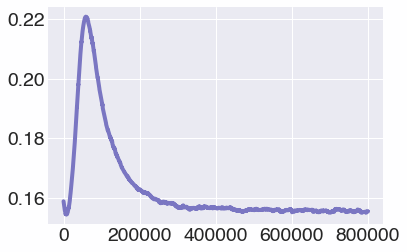

In [132]:
plt.plot(track)

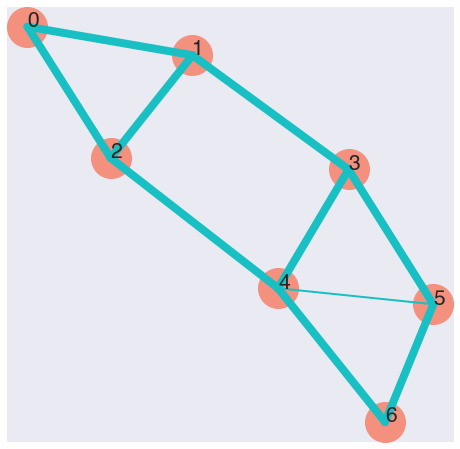

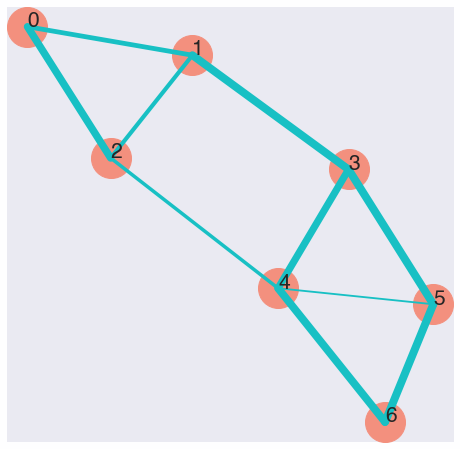

In [133]:
simpleDrawB1(B1, w, points, e=0, eps=0)
simpleDrawB1(B1, w, points, e, eps)

In [134]:
np.sqrt(w)+eps*e, np.sqrt(w)

(array([0.77196458, 0.96157155, 0.72042745, 0.99116596, 0.66150866,
        0.94522604, 0.99747549, 0.48004127, 0.98309549, 0.99585449]),
 array([1. , 1. , 1. , 1. , 1. , 1. , 1. , 0.5, 1. , 1. ]))

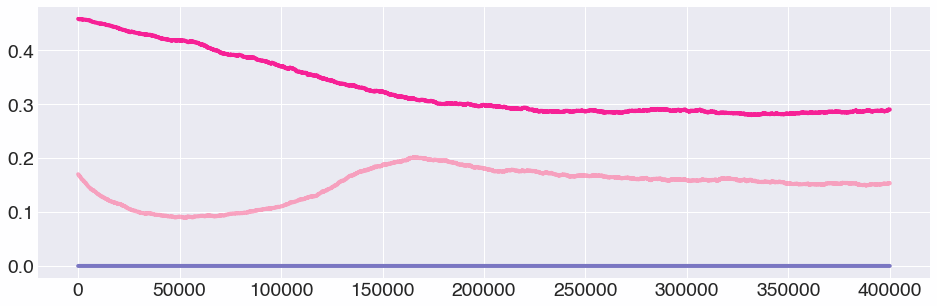

In [116]:
log=np.array(log)

plt.figure(figsize=(16, 5))
plt.plot(log[:, :3])

In [351]:
getL1k(L1_E)
np.linalg.eig(L1_E)[0]

array([ 6.37180129e+00,  4.92549874e+00,  3.15280449e+00,  2.88115436e+00,
        2.37430205e+00, -8.88413572e-16,  1.93850757e-02,  2.80974713e-01,
        1.07235256e+00,  6.91000102e-01])

In [335]:
points=getPosFromB1(B1)


In [336]:
def simpleDrawB1(B1, w, points, eps=0, e=0):
    
    plt.figure(figsize=(8,8))
    plt.plot(points[:,0], points[:,1], 'o', color=colors[4], markersize=40)
    for i in range(points.shape[0]):
        plt.annotate(str(i), (points[i,0], points[i,1]))
    for i in range(edges.shape[0]):
        plt.plot(points[edges[i].astype(int), 0], points[edges[i].astype(int), 1], color=colors[3], linewidth=8*((np.sqrt(w)+eps*e)**2)[i])
    plt.grid(False)
    plt.xticks([], [])
    plt.yticks([], [])

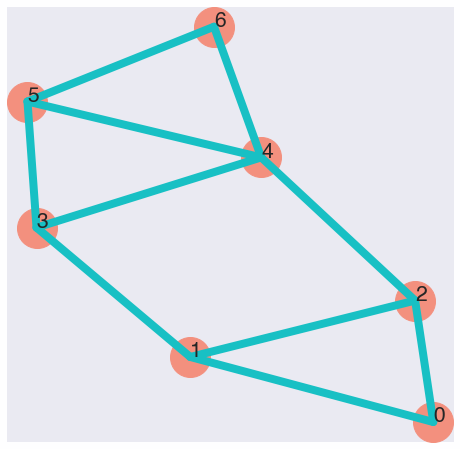

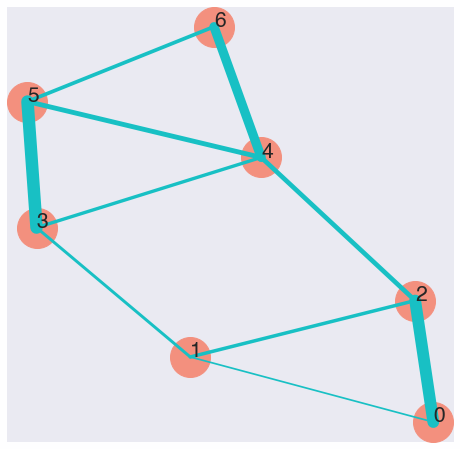

In [337]:
simpleDrawB1(B1, w, points, e=0, eps=0)
simpleDrawB1(B1, w, points, e, eps)

In [289]:
epses=np.hstack([[0.1, 0.2, 0.3, 0.4, 0.5, 0.6], np.arange(0.7, 0.71 , 0.001), [0.8]])
ans=[]
for eps in epses:
    #e=np.random.uniform(size=w.shape[0])
    #e=e/np.linalg.norm(e)
    e=np.array([1, 0, 0, 0, 0, 0, 0, 0,0,0])
    track=[]
    h=1e-3
    t_cur=0
    for i in range(10000):
        h=1e-3
        e0=e
        while True:
            e=e0
            dE=getDotE(B1, B2, w, e, eps, 1)
            E1=np.diag(e)+h*dE
            e=np.diag(E1)
            if np.sum(np.sqrt(w)+eps*e<0)>0:
                h=h/2
            else:
                break
        L1_E=HodgeLW_fr(B1, B2, w, e, eps)
        track.append(sqrt(getFk_l2(L1_E, 1)[0]))
        #track.append(np.sum((np.sort(np.linalg.eig(L1_E)[0])[:2])**2))
        dE=getDotE(B1, B2, w, e, eps, 1)
    ans.append(track[-1])
    #print(np.linalg.eig(L1_E)[0], )

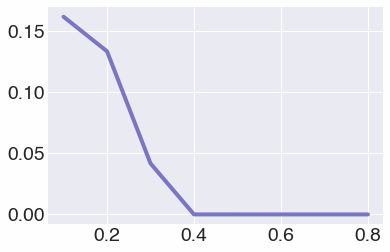

In [290]:
plt.plot(epses, ans)

In [291]:
ans[-1]

1.0200135035568666e-14

In [292]:
np.sqrt(w)+eps*e

array([1.72778562, 0.99595533, 0.99602147, 0.99906208, 0.96771224,
       0.97411972, 0.85596354, 0.82389728, 0.88421906, 1.20857357])

In [293]:
np.sqrt(w)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [294]:
L1_E=HodgeLW_fr(B1, B2, w, e, eps)
np.linalg.eig(L1_E)[0]

array([ 1.49341927e+01,  6.35631788e+00,  4.18733472e+00,  3.73140754e+00,
        2.88601596e+00,  1.58343674e+00,  7.35875640e-01,  5.62488979e-01,
       -2.00194551e-16,  1.01981703e-14])

In [138]:
e

array([-0.45607085, -0.0768569 , -0.55914511, -0.01766808, -0.67698268,
       -0.10954792, -0.00504902, -0.03991747, -0.03380901, -0.00829102])

In [137]:
T=np.abs(B2)


array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [145]:
np.array([1, 1, 1]).reshape(-1, 1).dot(e.reshape(-1, 1))

ValueError: shapes (3,1) and (10,1) not aligned: 1 (dim 1) != 10 (dim 0)

In [151]:
et=e.reshape(-1, 1)

In [156]:
et.dot(np.array([1, 1, 1]).reshape(-1, 1).T)

array([[-0.45607085, -0.45607085, -0.45607085],
       [-0.0768569 , -0.0768569 , -0.0768569 ],
       [-0.55914511, -0.55914511, -0.55914511],
       [-0.01766808, -0.01766808, -0.01766808],
       [-0.67698268, -0.67698268, -0.67698268],
       [-0.10954792, -0.10954792, -0.10954792],
       [-0.00504902, -0.00504902, -0.00504902],
       [-0.03991747, -0.03991747, -0.03991747],
       [-0.03380901, -0.03380901, -0.03380901],
       [-0.00829102, -0.00829102, -0.00829102]])

In [155]:
np.array([1, 1, 1]).reshape(-1, 1).T

array([[1, 1, 1]])

In [158]:
np.multiply((np.array([1, 1, 1]).reshape(-1, 1).dot(et.T)), T.T)

array([[-0.45607085, -0.0768569 , -0.55914511, -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.10954792, -0.00504902, -0.03991747, -0.        , -0.        ],
       [-0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.03991747, -0.03380901, -0.00829102]])

In [171]:
t=np.array([1e-6, 1e-7])
p=-10
np.mean(np.power(t, p))**(1/p)

1.0717734625255745e-07